In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from math import exp
from tqdm import tqdm

from rbm.lattices import Fine_RBM, A1_RBM
from rg.monotone import ResidualMLP
from utils.losses import free_energy_difference, free_energy_mse
from utils.newton import find_root
from utils.hmc import HMC
from utils.grad import grad

In [2]:
device = torch.device('cpu')

In [3]:
def plot(f, xlim=(0, 2), show_root=False):
    
    x_vals = torch.linspace(*xlim, 100, device=device).unsqueeze(1)
    
    f_vals = f(x_vals).cpu().detach()
    dfdx_vals = torch.cat([grad(f, x) for x in x_vals]).cpu().detach()
    x_vals = x_vals.cpu().detach()

    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    
    ax0.plot(x_vals, f_vals)
    ax0.set_ylabel(r'$f$')
    
    ax1.plot(x_vals, dfdx_vals)
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$\nabla \: f$')
    ax1.axhline(0, color='black', linewidth=0.5)
    ax1.axvline(0, color='black', linewidth=0.5)

    if show_root:
        root = find_root(torch.tensor([1.], device=device), lambda x : grad(C, x))

        if xlim[0] < root < xlim[1]:
            ax0.axvline(root, c='r', alpha=0.5, linestyle='dashed', linewidth=0.75)
            ax1.axvline(root, c='r', alpha=0.5, linestyle='dashed', linewidth=0.75)

# Models

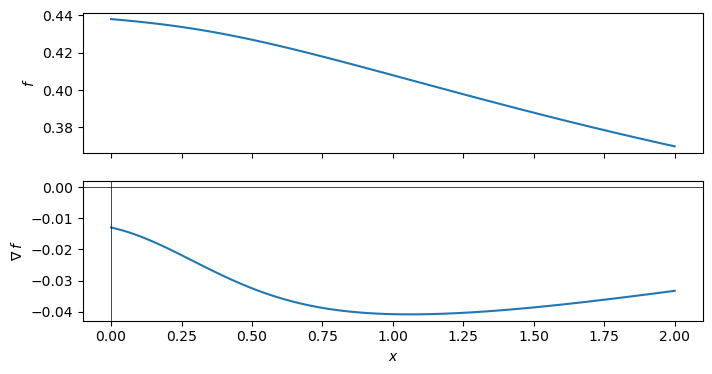

In [4]:
C = ResidualMLP(
    in_channels=1, 
    device=device
)

fine = Fine_RBM(device=device)
coarse = A1_RBM(device=device)

sampler = HMC()
sampler.potential = lambda J : 0

C.eval()
plot(C, show_root=True)

# Training

In [5]:
epoch = 0
epochs = 2048
batch_size = 64
k = 32
beta = lambda epoch : 4/(1 + exp(-0.01 * (epoch - (epochs / 2))))

In [6]:
optimizer = torch.optim.Adam(C.parameters())

Js = []
losses = []
J = torch.rand(1)

In [ ]:
C.train()

for epoch in tqdm(range(epoch, epoch + epochs)):
    optimizer.zero_grad()
    
    loss = 0

    sampler.potential = lambda J : beta(epoch) * -(grad(C, J) ** 2)

    J = sampler.step(J)
    Js.append(float(J))
    fine.J = J
    coarse.J = J - grad(C, J)

    loss = free_energy_difference(
        fine, coarse, 
        batch_size=batch_size, k=k
    )
    loss.backward()
    optimizer.step()

    losses.append(float(loss))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
ax0.plot(losses[::5])
ax1.plot(Js[::5])

 74%|████████████████████████████▊          | 1510/2048 [00:33<00:12, 41.96it/s]

In [ ]:
C.eval()
plot(C, xlim=(0, 2), show_root=True)